# Egent: LLM-Powered Equivalent Width Measurement

**A Pedagogical Tutorial**

This notebook provides a complete walkthrough of using Egent to measure equivalent widths (EW) from high-resolution stellar spectra. Egent combines classical multi-Voigt profile fitting with LLM-based visual inspection to achieve expert-level precision autonomously.

## What You'll Learn

1. How to obtain and configure an OpenAI API key
2. Understanding the input data format (spectrum and line list)
3. The physics behind Voigt profile fitting
4. Running the full EW measurement pipeline
5. Analyzing and visualizing results

## What is Equivalent Width?

The equivalent width of a spectral absorption line measures its integrated strength relative to the continuum. Mathematically:

$$W_\lambda = \int \frac{F_c(\lambda) - F(\lambda)}{F_c(\lambda)} \, d\lambda$$

where $F_c$ is the continuum flux and $F$ is the observed flux. The EW has units of wavelength (typically milli-Angstroms, mÅ) and directly encodes the number of absorbing atoms in the stellar atmosphere—making it fundamental to stellar abundance analysis.

## How Egent Works

Egent uses a **two-stage approach**:

1. **Direct Voigt Fitting**: For each line, Egent extracts a spectral window, estimates the continuum, and fits a multi-Voigt model. Quality metrics (RMS, χ², residual patterns) determine if the fit is acceptable.

2. **LLM Visual Inspection**: For borderline cases (poor quality metrics), the LLM receives a diagnostic plot and can:
   - Adjust the extraction window size
   - Add blend components for unresolved lines
   - Modify continuum treatment
   - Flag unreliable measurements

This mimics how a human expert would analyze spectra—but automatically and reproducibly.


---

# Part 1: Setup and Configuration

## 1.1 Getting an OpenAI API Key

Egent uses OpenAI's GPT-5-mini model for visual inspection of spectral fits. This model has vision capabilities that allow it to analyze diagnostic plots and make intelligent decisions about fit quality.

### How to Obtain Your API Key

1. **Create an account**: Go to [platform.openai.com](https://platform.openai.com) and sign up (or log in if you have an account)

2. **Add payment method**: Navigate to Settings → Billing and add a payment method. You only pay for what you use.

3. **Generate API key**: 
   - Go to [platform.openai.com/api-keys](https://platform.openai.com/api-keys)
   - Click **"Create new secret key"**
   - Give it a name like "Egent" 
   - Copy the key immediately (it starts with `sk-` and is shown only once!)

4. **Set spending limits** (recommended): In Billing → Limits, set a monthly budget to avoid surprises

### Pricing Information

GPT-5-mini is very cost-effective for scientific applications:
- **Cost**: ~$0.005 per spectral line (approximately 200 lines per dollar)
- **Typical run**: A spectrum with 200 lines costs about $1
- **Most lines**: Are accepted by direct fitting without LLM (free), so actual costs are lower

The LLM is only invoked for borderline cases where quality metrics indicate uncertainty.


## 1.2 Install Dependencies and Set API Key

Run the cell below to install required packages and configure your API key. This notebook is self-contained—all dependencies are installed directly here.


In [ ]:
# Install required packages (runs once, then can be commented out)
%pip install -q numpy pandas scipy matplotlib openai

# =============================================================================
# ⚠️ SET YOUR OPENAI API KEY HERE ⚠️
# =============================================================================
# Replace the placeholder below with your actual OpenAI API key

import os
os.environ['OPENAI_API_KEY'] = 'YOUR_OPENAI_API_KEY_HERE'  # <-- PASTE YOUR KEY HERE

# Verify the key is configured correctly
key = os.environ.get('OPENAI_API_KEY', '')
if key.startswith('sk-') and len(key) > 20:
    print("✅ API key configured successfully!")
else:
    print("⚠️  Please paste your OpenAI API key in the cell above")
    print("   It should start with 'sk-' and be about 50 characters long")


Note: you may need to restart the kernel to use updated packages.
✅ API key configured successfully!


In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import base64
from IPython.display import Image, display

# Configure matplotlib for inline display
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 11

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


---

# Part 2: Understanding the Input Data

Egent requires two simple input files:

1. **Spectrum file** (CSV): Contains the observed spectrum with columns for wavelength, flux, and flux uncertainty
2. **Line list file** (CSV): Contains the wavelengths of spectral lines you want to measure

Both files should be in CSV format. The spectrum must be in the **stellar rest frame**—meaning any radial velocity and barycentric corrections should already be applied.

## 2.1 Loading and Examining the Spectrum

The example spectrum is a portion of a high-resolution Magellan/MIKE observation covering 6100-6200 Å. This wavelength range contains several Fe I, Si I, and Na I lines commonly used for stellar abundance analysis.


In [2]:
# Load the example spectrum
spectrum = pd.read_csv('example/spectrum.csv')

# Display the data format
print("SPECTRUM FILE FORMAT")
print("=" * 50)
print(spectrum.head(10).to_string(index=False))
print(f"\n... ({len(spectrum)} rows total)")

# Show summary statistics
print("\nSUMMARY STATISTICS")
print("=" * 50)
print(f"Wavelength range: {spectrum['wavelength'].min():.2f} - {spectrum['wavelength'].max():.2f} Å")
print(f"Number of pixels: {len(spectrum)}")

# Calculate SNR
spectrum['snr'] = spectrum['flux'] / spectrum['flux_error']
print(f"Signal-to-Noise: {spectrum['snr'].min():.0f} - {spectrum['snr'].max():.0f} (median: {spectrum['snr'].median():.0f})")


SPECTRUM FILE FORMAT
 wavelength         flux  flux_error
6100.025902 90438.203125  302.814209
6100.069049 91261.304688  304.131348
6100.112197 91475.125000  304.491425
6100.155344 90175.703125  302.456360
6100.198491 91162.492188  304.041321
6100.241638 90140.054688  302.338379
6100.284786 89792.343750  301.837616
6100.327933 89873.539062  301.834167
6100.371080 89723.773438  301.747955
6100.414227 88113.601562  299.027008

... (2318 rows total)

SUMMARY STATISTICS
Wavelength range: 6100.03 - 6200.00 Å
Number of pixels: 2318
Signal-to-Noise: 179 - 349 (median: 319)


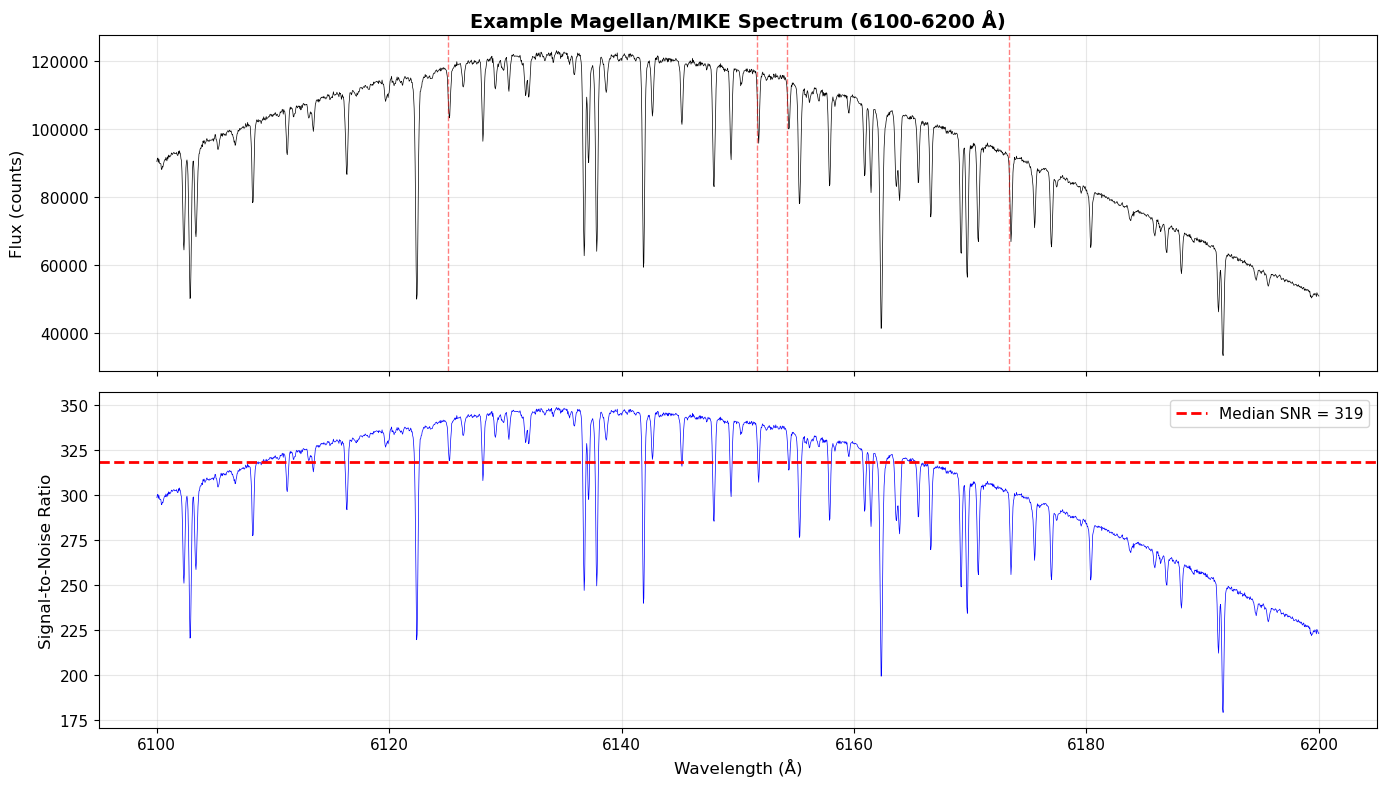


Red dashed lines mark example absorption features that will be measured.


In [3]:
# Visualize the spectrum
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Top panel: Flux spectrum
ax1 = axes[0]
ax1.plot(spectrum['wavelength'], spectrum['flux'], 'k-', lw=0.5)
ax1.set_ylabel('Flux (counts)', fontsize=12)
ax1.set_title('Example Magellan/MIKE Spectrum (6100-6200 Å)', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

# Mark some absorption lines
lines_to_mark = [6125.03, 6151.62, 6154.23, 6173.34]
for wave in lines_to_mark:
    ax1.axvline(wave, color='red', ls='--', alpha=0.5, lw=1)

# Bottom panel: SNR
ax2 = axes[1]
ax2.plot(spectrum['wavelength'], spectrum['snr'], 'b-', lw=0.5)
ax2.axhline(spectrum['snr'].median(), color='red', ls='--', lw=2, 
            label=f'Median SNR = {spectrum["snr"].median():.0f}')
ax2.set_xlabel('Wavelength (Å)', fontsize=12)
ax2.set_ylabel('Signal-to-Noise Ratio', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nRed dashed lines mark example absorption features that will be measured.")


## 2.2 Loading the Line List

The line list specifies which spectral lines to measure. Each line is identified by its rest wavelength. The example line list contains 14 lines from various elements commonly used in stellar abundance analysis:

- **Fe I** (Iron): The most abundant metal, used for metallicity and as a reference
- **Si I** (Silicon): An alpha-element produced in core-collapse supernovae
- **Na I** (Sodium): Traces nucleosynthesis and stellar populations
- **Ba II** (Barium): A neutron-capture element


In [4]:
# Load and display the line list
linelist = pd.read_csv('example/linelist.csv')

print("LINE LIST FILE FORMAT")
print("=" * 50)
print(linelist.to_string(index=False))
print(f"\nTotal: {len(linelist)} lines to measure")


LINE LIST FILE FORMAT
 wavelength
    6125.03
    6127.91
    6141.71
    6142.49
    6145.02
    6151.62
    6154.23
    6157.72
    6160.75
    6165.36
    6170.51
    6173.34
    6180.20
    6187.99

Total: 14 lines to measure


---

# Part 3: The Physics of Voigt Profile Fitting

## 3.1 Line Broadening Mechanisms

Spectral absorption lines are not infinitely narrow—they are broadened by several physical mechanisms:

1. **Natural broadening** (Lorentzian): From the finite lifetime of excited atomic states, giving a Lorentzian profile with characteristic width γ

2. **Thermal broadening** (Gaussian): From the Maxwell-Boltzmann velocity distribution of absorbing atoms, giving a Gaussian profile with width σ proportional to √(T/m)

3. **Pressure/collisional broadening** (Lorentzian): From interactions with other atoms in the stellar atmosphere

4. **Instrumental broadening** (approximately Gaussian): From the spectrograph's finite resolving power

## 3.2 The Voigt Profile

The **Voigt profile** is the convolution of Gaussian and Lorentzian profiles, capturing both thermal and pressure broadening:

$$V(\lambda; \lambda_0, A, \sigma, \gamma) = A \cdot \frac{\text{Re}[w(z)]}{\sigma\sqrt{2\pi}}$$

where $w(z)$ is the Faddeeva function and $z = \frac{(\lambda - \lambda_0) + i\gamma}{\sigma\sqrt{2}}$.

The four Voigt parameters are:
- **λ₀**: Line center wavelength
- **A**: Amplitude (absorption depth)
- **σ**: Gaussian width (thermal + instrumental)
- **γ**: Lorentzian width (natural + pressure)

The equivalent width is then computed by integrating the Voigt profile.


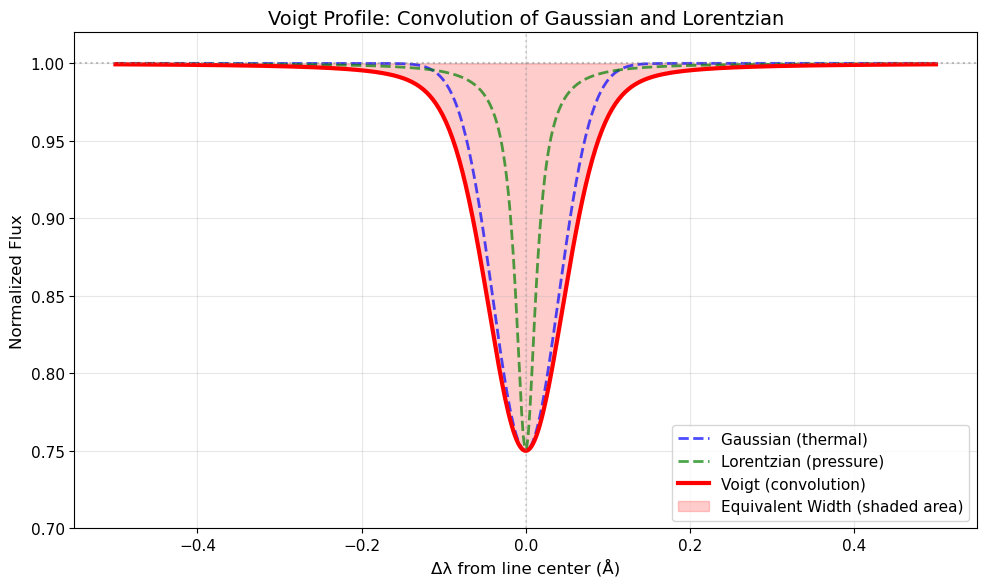

Voigt parameters: σ = 0.04 Å, γ = 0.015 Å
FWHM ≈ 0.094 Å
Equivalent Width = 32.4 mÅ


In [5]:
# Visualize Voigt profile components
from scipy.special import voigt_profile

# Create wavelength grid centered on line
wavelength = np.linspace(-0.5, 0.5, 500)

# Typical parameters for a stellar absorption line
sigma = 0.04   # Gaussian width (Å) - thermal + instrumental
gamma = 0.015  # Lorentzian width (Å) - pressure broadening
amplitude = 0.25  # Absorption depth (25% of continuum)

# Calculate profiles
voigt = voigt_profile(wavelength, sigma, gamma)
voigt_norm = voigt / voigt.max() * amplitude

gaussian = amplitude * np.exp(-wavelength**2 / (2 * sigma**2))
lorentzian = amplitude * gamma**2 / (wavelength**2 + gamma**2)

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(wavelength, 1 - gaussian, 'b--', lw=2, alpha=0.7, label='Gaussian (thermal)')
ax.plot(wavelength, 1 - lorentzian, 'g--', lw=2, alpha=0.7, label='Lorentzian (pressure)')
ax.plot(wavelength, 1 - voigt_norm, 'r-', lw=3, label='Voigt (convolution)')
ax.axhline(1, color='gray', ls=':', alpha=0.5)
ax.axvline(0, color='gray', ls=':', alpha=0.3)

ax.fill_between(wavelength, 1, 1 - voigt_norm, alpha=0.2, color='red', 
                label='Equivalent Width (shaded area)')

ax.set_xlabel('Δλ from line center (Å)', fontsize=12)
ax.set_ylabel('Normalized Flux', fontsize=12)
ax.set_title('Voigt Profile: Convolution of Gaussian and Lorentzian', fontsize=14)
ax.legend(loc='lower right', fontsize=11)
ax.set_ylim(0.7, 1.02)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and display EW
from scipy.integrate import trapezoid
ew = trapezoid(voigt_norm, wavelength) * 1000  # Convert to mÅ
print(f"Voigt parameters: σ = {sigma} Å, γ = {gamma} Å")
print(f"FWHM ≈ {2.355 * sigma:.3f} Å")
print(f"Equivalent Width = {ew:.1f} mÅ")


---

# Part 4: Running the EW Measurement Pipeline

Now we'll run Egent on all lines in the line list. The pipeline will:

1. **For each line**: Extract a spectral window, estimate the continuum, and fit a multi-Voigt model
2. **Quality assessment**: Compute RMS, χ², and check for residual patterns
3. **LLM review**: If quality metrics indicate problems, the LLM inspects the diagnostic plot and can:
   - Adjust the window size
   - Add blend components
   - Change continuum method
   - Flag unreliable measurements
4. **Output**: Save results JSON and diagnostic plots

The `clean_plots=True` option removes temporary LLM working plots after completion, keeping only the final diagnostic plots.


In [ ]:
# Run the EW measurement pipeline
from run_ew import run_ew_analysis

# Define output directory
output_dir = './tutorial_output'

# Run the pipeline
# - n_workers: number of parallel threads (adjust based on API rate limits)
# - clean_plots: remove temporary LLM working plots after completion
results = run_ew_analysis(
    spectrum_file='example/spectrum.csv',
    linelist_file='example/linelist.csv',
    n_workers=3,
    output_dir=output_dir,
    clean_plots=True  # Clean up temp plots when done
)


Spectrum: example/spectrum.csv
  2318 points, 6100.0-6200.0 Å
  Median SNR: 319

Line list: example/linelist.csv
  14 lines to measure

EGENT EW ANALYSIS: 14 lines
Model: gpt-5-mini | Workers: 3
Started: 2025-12-01 18:27:42

    [1/14] 6125.03Å: Direct=28.5mÅ (poor) → LLM (poor_quality)
    [3/14] 6141.71Å: Direct=122.3mÅ (poor) → LLM (poor_quality)
    [4/14] 6142.49Å: Direct=32.8mÅ (poor) → LLM (poor_quality)
[  1/14]  6127.91 Å | ✓ 45.4±2.1 mÅ 0.0s
[  2/14]  6125.03 Å | 🔄 28.5±1.6 mÅ 29.6s
    [5/14] 6145.02Å: Direct=34.8mÅ (poor) → LLM (poor_quality)
[  3/14]  6142.49 Å | 🔄 32.8±1.9 mÅ 32.2s
    [6/14] 6151.62Å: Direct=35.7mÅ (poor) → LLM (poor_quality)
[  4/14]  6151.62 Å | 🔄 35.7±1.5 mÅ 17.1s
    [7/14] 6154.23Å: Direct=28.9mÅ (poor) → LLM (poor_quality)


---

# Part 5: Analyzing the Results

## 5.1 Results Summary

Let's examine the measurement results. Each line has:
- **measured_ew**: The equivalent width in milli-Angstroms (mÅ)
- **ew_err**: Uncertainty from the covariance matrix
- **fit_quality**: 'good', 'acceptable', or 'poor'
- **used_llm**: Whether LLM intervention was needed
- **flagged**: Whether the line was flagged as unreliable


In [ ]:
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Display summary statistics
print("=" * 70)
print("RESULTS SUMMARY")
print("=" * 70)

# Count by category
n_total = len(results_df)
n_success = len(results_df[results_df['success'] == True])
n_flagged = len(results_df[results_df['flagged'] == True])
n_direct = len(results_df[(results_df['used_llm'] == False) & (results_df['success'] == True)])
n_llm = len(results_df[(results_df['used_llm'] == True) & (results_df['flagged'] != True)])

print(f"\nTotal lines measured: {n_total}")
print(f"  ✓ Successful: {n_success}")
print(f"  🚩 Flagged: {n_flagged}")
print(f"\nMethod breakdown:")
print(f"  Direct fits (no LLM): {n_direct}")
print(f"  LLM-refined: {n_llm}")


In [ ]:
# Display all measurements in a nice table
print("\n" + "=" * 70)
print("INDIVIDUAL MEASUREMENTS")
print("=" * 70)
print(f"{'Wavelength':>10} {'EW (mÅ)':>12} {'Error':>8} {'Quality':>12} {'Method':>8} {'Status':>10}")
print("-" * 70)

for _, row in results_df.iterrows():
    wave = row['wavelength']
    
    if row.get('flagged'):
        status = "FLAGGED"
        ew_str = "---"
        err_str = "---"
        quality = row.get('flag_reason', 'unknown')[:12]
        method = "---"
    elif row.get('measured_ew'):
        status = "OK"
        ew_str = f"{row['measured_ew']:.1f}"
        err_str = f"±{row.get('ew_err', 0):.1f}"
        quality = row.get('fit_quality', 'N/A')
        method = "LLM" if row.get('used_llm') else "Direct"
    else:
        status = "FAILED"
        ew_str = "---"
        err_str = "---"
        quality = "---"
        method = "---"
    
    print(f"{wave:>10.2f} {ew_str:>12} {err_str:>8} {quality:>12} {method:>8} {status:>10}")


## 5.2 Reading the Output JSON File

Egent saves complete results to a JSON file including all metadata, Voigt parameters, and LLM conversation logs. This provides full provenance for every measurement—you can exactly reconstruct any fit from the saved parameters.


In [ ]:
# Find and load the results JSON file
results_files = sorted(Path(output_dir).glob('results_*.json'))

if results_files:
    json_file = results_files[-1]  # Most recent
    print(f"Loading: {json_file}")
    
    with open(json_file) as f:
        full_results = json.load(f)
    
    # Display structure
    print("\n" + "=" * 70)
    print("JSON FILE STRUCTURE")
    print("=" * 70)
    print(f"\nTop-level keys: {list(full_results.keys())}")
    
    print(f"\n📋 metadata:")
    for k, v in full_results['metadata'].items():
        print(f"   {k}: {v}")
    
    print(f"\n📊 summary:")
    for k, v in full_results['summary'].items():
        print(f"   {k}: {v}")
    
    print(f"\n📈 results: {len(full_results['results'])} line entries")
else:
    print("No results file found. Run the pipeline first.")


In [ ]:
# Examine one result in detail - shows the full data structure
print("=" * 70)
print("DETAILED RESULT EXAMPLE")
print("=" * 70)

# Find a successful measurement
for r in full_results['results']:
    if r.get('success') and r.get('measured_ew') and not r.get('flagged'):
        print(f"\nLine: {r['wavelength']:.2f} Å")
        print(f"\n🎯 MEASUREMENT:")
        print(f"   EW: {r['measured_ew']:.2f} ± {r.get('ew_err', 0):.2f} mÅ")
        print(f"   Fit quality: {r.get('fit_quality', 'N/A')}")
        print(f"   Method: {'LLM-refined' if r.get('used_llm') else 'Direct fit'}")
        
        # Voigt parameters - these allow exact reconstruction
        if r.get('direct_voigt_params') and r['direct_voigt_params'].get('target'):
            vp = r['direct_voigt_params']['target']
            print(f"\n📐 VOIGT PARAMETERS (for reconstruction):")
            print(f"   Center (λ₀): {vp['center']:.4f} Å")
            print(f"   Amplitude (A): {vp['amplitude']:.4f}")
            print(f"   Gaussian σ: {vp['sigma']:.5f} Å")
            print(f"   Lorentzian γ: {vp['gamma']:.5f} Å")
            print(f"   FWHM: {vp.get('fwhm', 0):.4f} Å")
        
        # Continuum info
        if r.get('continuum_info'):
            ci = r['continuum_info']
            print(f"\n📏 CONTINUUM:")
            print(f"   Method: {ci.get('method', 'N/A')}")
            if ci.get('fitted_continuum_coeffs'):
                print(f"   Polynomial coefficients: {ci['fitted_continuum_coeffs']}")
        
        # LLM reasoning (if used)
        if r.get('used_llm') and r.get('iterations'):
            print(f"\n🤖 LLM REASONING:")
            for i, it in enumerate(r['iterations'][:2]):  # Show first 2 iterations
                print(f"   Iteration {i+1}: {it.get('thought', 'N/A')[:80]}...")
        
        break


---

# Part 6: Viewing Diagnostic Plots

Egent generates diagnostic plots for every measured line, organized into subdirectories by result type:

- **`fits/direct/`**: Lines successfully fitted without LLM intervention
- **`fits/llm/`**: Lines where LLM improved the fit
- **`fits/flagged/`**: Lines flagged as unreliable
- **`fits/error/`**: Lines that encountered errors

Each plot shows the normalized spectrum, multi-Voigt fit, and residuals with quality metrics.


In [ ]:
# List available diagnostic plots
fits_dir = Path(output_dir) / 'fits'

if fits_dir.exists():
    print("AVAILABLE DIAGNOSTIC PLOTS")
    print("=" * 70)
    
    for subdir in ['direct', 'llm', 'flagged', 'error']:
        subpath = fits_dir / subdir
        if subpath.exists():
            plots = sorted(subpath.glob('*.png'))
            print(f"\n📁 {subdir}/ ({len(plots)} plots)")
            for p in plots[:5]:  # Show first 5
                print(f"   • {p.name}")
            if len(plots) > 5:
                print(f"   ... and {len(plots) - 5} more")
else:
    print("No plots directory found. Run the pipeline first.")


In [ ]:
# Display example plots from each category
print("EXAMPLE DIAGNOSTIC PLOTS")
print("=" * 70)

for subdir in ['direct', 'llm', 'flagged']:
    subpath = fits_dir / subdir
    if subpath.exists():
        plots = sorted(subpath.glob('*.png'))
        if plots:
            print(f"\n{'='*70}")
            print(f"📊 {subdir.upper()} FIT EXAMPLE: {plots[0].name}")
            print(f"{'='*70}")
            display(Image(filename=str(plots[0]), width=700))


## 6.1 Understanding the Diagnostic Plots

Each diagnostic plot contains two panels:

**Top Panel - Normalized Spectrum:**
- **Black line**: Observed data, normalized by the fitted continuum
- **Red line**: Multi-Voigt model fit
- **Blue dashed line**: Target wavelength (the line you're measuring)
- **Green/Orange dashed lines**: Centers of fitted Voigt components (green = target, orange = blends)
- **Gray horizontal line**: Continuum level (1.0)

**Bottom Panel - Residuals:**
- Shows (data - model) normalized by the flux uncertainty
- **Green band**: ±1σ range (68% of points should fall here for a good fit)
- **Yellow band**: ±2σ range (95% of points should fall here)
- **RMS value**: Root-mean-square of normalized residuals (should be ~1.0 for a good fit)

### Quality Interpretation
- **RMS < 1.5σ**: Excellent fit
- **RMS 1.5-2.0σ**: Good fit  
- **RMS 2.0-2.5σ**: Marginal (LLM reviews these)
- **RMS > 2.5σ**: Poor fit (usually flagged)


---

# Summary and Next Steps

## What We Covered

In this tutorial, you learned:

1. **Setup**: How to obtain an OpenAI API key and configure Egent
2. **Input data**: The simple CSV format for spectra and line lists
3. **Physics**: How Voigt profiles model spectral absorption lines
4. **Pipeline**: How Egent combines direct fitting with LLM visual inspection
5. **Output**: How to read the results JSON and interpret diagnostic plots

## Using Your Own Data

To analyze your own spectra:

1. **Prepare your spectrum**: Create a CSV with columns `wavelength`, `flux`, `flux_error`
   - Wavelengths must be in the stellar rest frame (apply barycentric + RV corrections first)
   - Any flux units work (Egent normalizes internally)

2. **Create your line list**: CSV with column `wavelength` containing rest wavelengths to measure

3. **Run the analysis**:
```python
results = run_ew_analysis(
    spectrum_file='your_spectrum.csv',
    linelist_file='your_linelist.csv',
    n_workers=5,
    output_dir='./output'
)
```

## Tips for Best Results

- **High SNR**: Egent works best with SNR > 50 per pixel
- **Clean continuum**: Avoid regions with strong molecular bands or emission
- **Isolated lines**: Heavily blended lines may require manual continuum regions
- **Rest frame**: Always ensure spectra are in the stellar rest frame

## Troubleshooting

| Issue | Solution |
|-------|----------|
| API rate limit errors | Reduce `n_workers` (try 2-3) |
| Many flagged lines | Check wavelength calibration, may need rest-frame correction |
| Poor fits | Try `set_continuum_method('polynomial', order=2)` |
| Missing lines | Ensure lines fall within spectrum wavelength range |

## Citation

If you use Egent in your research, please cite:

```
Ting et al. (2025), "Egent: An Autonomous Agent for Equivalent Width Measurement"
```
